<img src="../images/logos/xradar_logo.svg" width=250 alt="xradar"></img>

# Xradar Basics


---

## Overview

1. Xradar general overview
1. Radar data IO
2. Radar data georeferencing
3. Data visualization
   

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray) | Necessary |  Basic features |
| [Radar Cookbook](https://projectpythia.org/radar-cookbook/) | Necessary |  Radar basics |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib) | Necessary |  Plotting basic features |
- **Time to learn**: 30 minutes
---

## Imports

In [1]:
import xradar as xd
import pyart
import wradlib as wrl

import fsspec
import numpy as np
from xarray.backends.api import open_datatree

import matplotlib.pyplot as plt
import cartopy.crs as ccrs


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Xradar

`Xradar` is a `Python` package developed to streamline the **reading** and **writing** of radar data across various formats, with exports aligned to standards like ODIM_H5 and CfRadial. Born from the **Open Radar Science Community's** collaboration at **ERAD2022**, `Xradar` uses an `xarray-based` data model, compatible with the upcoming **CfRadial2.1/FM301** standard. This ensures seamless integration with other xarray-based software and existing open-source radar processing tools.

### Xradar data model
Xradar leverages the upcoming FM301 standard, a subset of CfRadial2.0, using Xarray to efficiently manage radar data.

#### DataTree Structure (CfRadial2.1/FM301 standard)
Xradar employs `xarray.DataTree` objects to organize radar sweeps within a single structure, where each sweep is an `xarray.Dataset` containing relevant metadata and variables.

<img src="../images/CfRadial2.1.svg" width=500 alt="xradar"></img>

## Xradar importers

Xradar supports several importers to handle different radar data formats. These importers typically include:

- **ODIM_H5**: For reading radar data in the ODIM_H5 format, which is widely used in Europe and supported by the EUMETNET OPERA program.

- **CfRadial**: For importing data in the CfRadial format, which is commonly used in the atmospheric sciences community.

- **SIGMET/IRIS**: For ingesting radar data from SIGMET/IRIS formats, which are used by various weather radar systems globally.

- **GAMIC**: For reading data from GAMIC radars, which use their proprietary format.

For more importers check [here](https://docs.openradarscience.org/projects/xradar/en/stable/importers.html)

Let's find some Canadian radar data from the May 2022 Ontario Derecho case located at the AMS 2025 Bucket

In [2]:
# Set the URL and path for the cloud
URL = 'https://js2.jetstream-cloud.org:8001/'
path = f'pythia/radar/ams2025'

fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL))

fs.glob(f"{path}/*")

['pythia/radar/ams2025/CASET.zarr',
 'pythia/radar/ams2025/CASKR.zarr',
 'pythia/radar/ams2025/CASSM.zarr',
 'pythia/radar/ams2025/CalgaryHailStorm2024',
 'pythia/radar/ams2025/OntarioDerecho2022',
 'pythia/radar/ams2025/ams2025_titan.raw.tgz',
 'pythia/radar/ams2025/lrose']

In [3]:
# Get Canadian radar data from Ontario Derecho 2022 event
files = fs.glob("pythia/radar/ams2025/OntarioDerecho2022/*.h5")
files[:3]

['pythia/radar/ams2025/OntarioDerecho2022/2022052115_00_ODIMH5_PVOL6S_VOL_CASET.h5',
 'pythia/radar/ams2025/OntarioDerecho2022/2022052115_00_ODIMH5_PVOL6S_VOL_CASKR.h5',
 'pythia/radar/ams2025/OntarioDerecho2022/2022052115_06_ODIMH5_PVOL6S_VOL_CASET.h5']

In [4]:
# Create S3 file paths for radar data
radar_files = [f"s3://{i}" for i in files]
print(f"Found {len(radar_files)} radar files")
radar_files[:3]

Found 78 radar files


['s3://pythia/radar/ams2025/OntarioDerecho2022/2022052115_00_ODIMH5_PVOL6S_VOL_CASET.h5',
 's3://pythia/radar/ams2025/OntarioDerecho2022/2022052115_00_ODIMH5_PVOL6S_VOL_CASKR.h5',
 's3://pythia/radar/ams2025/OntarioDerecho2022/2022052115_06_ODIMH5_PVOL6S_VOL_CASET.h5']

In [5]:
# Setup local file caching for efficient data access
local_files = [
    fsspec.open_local(
        f"simplecache::{URL}{i}", s3={"anon": True}, filecache={"cache_storage": "."}
    )
    for i in files[:3]  # Use first 3 files for this example
]

We can open one of these Canadian radar files (ODIM_H5 format) using the `xradar.io.open_odim_datatree` method

In [6]:
# Open the Canadian radar data using xradar
dt = xd.io.open_odim_datatree(local_files[0])
display(dt)

<xarray.DataTree>
Group: /
│   Dimensions:              (sweep: 17)
│   Dimensions without coordinates: sweep
│   Data variables:
│       volume_number        int64 8B 0
│       platform_type        <U5 20B 'fixed'
│       instrument_type      <U5 20B 'radar'
│       time_coverage_start  <U20 80B '2022-05-21T14:54:03Z'
│       time_coverage_end    <U20 80B '2022-05-21T14:59:48Z'
│       longitude            float64 8B -81.38
│       altitude             float64 8B 365.4
│       latitude             float64 8B 43.37
│       sweep_fixed_angle    (sweep) float64 136B 24.4 21.2 18.0 ... 1.2 0.8 0.4
│       sweep_group_name     (sweep) int64 136B 0 1 2 3 4 5 6 ... 11 12 13 14 15 16
│   Attributes:
│       Conventions:      ODIM_H5/V2_2
│       instrument_name:  None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
├── Group: /sweep_0
│       Dimensions:            (azimuth: 360, range: 245)
│       Coordinates:
│         * azimuth            (azimuth) float64 3kB 0.4945 1.502 2.507 ... 358.5 359.5
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2022-05-21T14:54:06.58332...
│         * range              (range) float32 980B 250.0 750.0 ... 1.218e+05 1.222e+05
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│       Data variables: (12/15)
│           DBZH               (azimuth, range) float64 706kB ...
│           TH                 (azimuth, range) float64 706kB ...
│           RHOHV              (azimuth, range) float64 706kB ...
│           UPHIDP             (azimuth, range) float64 706kB ...
│           WRADH              (azimuth, range) float64 706kB ...
│           PHIDP              (azimuth, range) float64 706kB ...
│           ...                 ...
│           VRADH              (azimuth, range) float64 706kB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
├── Group: /sweep_1
│       Dimensions:            (azimuth: 360, range: 245)
│       Coordinates:
│         * azimuth            (azimuth) float64 3kB 0.4915 1.497 2.502 ... 358.5 359.5
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2022-05-21T14:54:21.41666...
│         * range              (range) float32 980B 250.0 750.0 ... 1.218e+05 1.222e+05
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│       Data variables: (12/15)
│           DBZH               (azimuth, range) float64 706kB ...
│           TH                 (azimuth, range) float64 706kB ...
│           RHOHV              (azimuth, range) float64 706kB ...
│           UPHIDP             (azimuth, range) float64 706kB ...
│           WRADH              (azimuth, range) float64 706kB ...
│           PHIDP              (azimuth, range) float64 706kB ...
│           ...                 ...
│           VRADH              (azimuth, range) float64 706kB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
├── Group: /sweep_2
│       Dimensions:            (azimuth: 360, range: 245)
│       Coordinates:
│         * azimuth            (azimuth) float64 3kB 0.5055 1.511 2.502 ... 358.5 359.5
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2022-05-21T14:54:36.21665...
│         * range              (range) f

This `Xarray.DataTree` object contains the radar metadata in the root node and individual `Xarray.Datasets` for each elevation sweep. Canadian radar data typically uses ODIM_H5 format with variables like DBZH (reflectivity), VRADH (velocity), and others.

In [7]:
# Let's explore the elevation angles available in this radar volume
for sweep in dt.children:
    try:
        elevation = np.round(dt[sweep]['sweep_fixed_angle'].values, 1)
        print(f"{sweep} - elevation angle: {elevation}°")
    except KeyError:
        print(f"{sweep} - metadata node")

sweep_0 - elevation angle: 24.4°
sweep_1 - elevation angle: 21.2°
sweep_2 - elevation angle: 18.0°
sweep_3 - elevation angle: 14.8°
sweep_4 - elevation angle: 11.6°
sweep_5 - elevation angle: 10.0°
sweep_6 - elevation angle: 8.4°
sweep_7 - elevation angle: 6.8°
sweep_8 - elevation angle: 5.2°
sweep_9 - elevation angle: 4.4°
sweep_10 - elevation angle: 3.6°
sweep_11 - elevation angle: 2.8°
sweep_12 - elevation angle: 2.0°
sweep_13 - elevation angle: 1.6°
sweep_14 - elevation angle: 1.2°
sweep_15 - elevation angle: 0.8°
sweep_16 - elevation angle: 0.4°
radar_parameters - metadata node
georeferencing_correction - metadata node
radar_calibration - metadata node


Let's explore the lowest elevation sweep (closest to the ground) to see storm features better

In [8]:
# Get the lowest elevation sweep (typically sweep_0)
# Find the sweep with the minimum elevation angle
sweep_elevations = {}
for sweep in dt.children:
    if 'sweep' in sweep:
        try:
            elev = dt[sweep]['sweep_fixed_angle'].values
            sweep_elevations[sweep] = elev
        except KeyError:
            pass

# Find the sweep with minimum elevation
min_sweep = min(sweep_elevations, key=sweep_elevations.get)
print(f"Using {min_sweep} with elevation: {sweep_elevations[min_sweep]:.1f}°")

ds_lowest = dt[min_sweep].ds
display(ds_lowest)

Using sweep_16 with elevation: 0.4°


<xarray.DatasetView> Size: 28MB
Dimensions:            (azimuth: 720, range: 480)
Coordinates:
  * azimuth            (azimuth) float64 6kB 0.258 0.7495 1.252 ... 359.3 359.8
    elevation          (azimuth) float64 6kB ...
    time               (azimuth) datetime64[ns] 6kB 2022-05-21T14:59:19.04791...
  * range              (range) float32 2kB 250.0 750.0 ... 2.392e+05 2.398e+05
    longitude          float64 8B ...
    latitude           float64 8B ...
    altitude           float64 8B ...
Data variables: (12/15)
    DBZH               (azimuth, range) float64 3MB ...
    TH                 (azimuth, range) float64 3MB ...
    RHOHV              (azimuth, range) float64 3MB ...
    UPHIDP             (azimuth, range) float64 3MB ...
    WRADH              (azimuth, range) float64 3MB ...
    PHIDP              (azimuth, range) float64 3MB ...
    ...                 ...
    VRADH              (azimuth, range) float64 3MB ...
    sweep_mode         <U20 80B ...
    sweep_number       int64 8B ...
    prt_mode           <U7 28B ...
    follow_mode        <U7 28B ...
    sweep_fixed_angle  float64 8B 0.4

## Xradar visualization

We can make a plot using [`xarray.plot`](https://docs.xarray.dev/en/latest/user-guide/plotting.html) functionality.

Text(0, 0.5, 'Range (meters)')

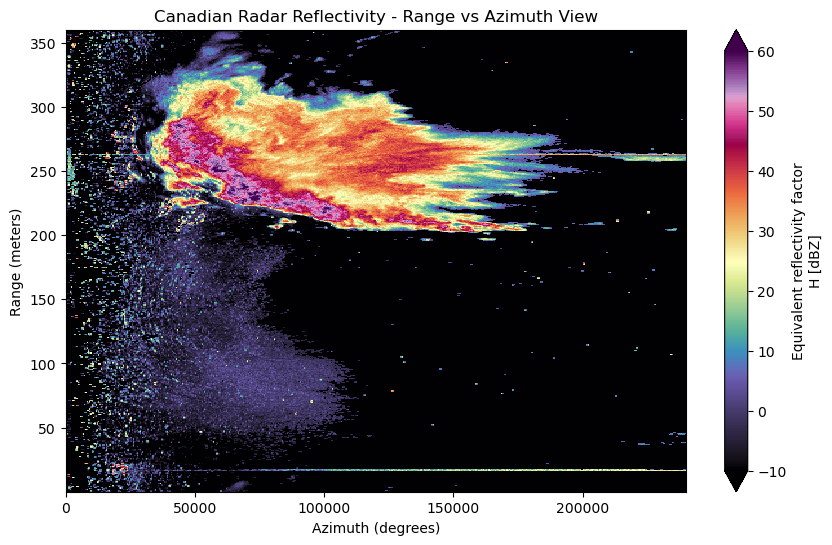

In [9]:
# Plot reflectivity (DBZH) using basic xarray plotting
ds_lowest.DBZH.plot(
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10, 
    figsize=(10, 6)
)
plt.title('Canadian Radar Reflectivity - Range vs Azimuth View')
plt.xlabel('Azimuth (degrees)')
plt.ylabel('Range (meters)')

The above plot shows radar data in "polar coordinates" (range vs azimuth). For a more intuitive view, we need to convert to "Cartesian coordinates" (x, y positions). The [`xradar.georeference`](https://docs.openradarscience.org/projects/xradar/en/stable/georeference.html) method converts polar radar coordinates to geographic x, y, and z coordinates.

In [10]:
# Convert from polar coordinates (range, azimuth) to Cartesian coordinates (x, y)
ds_lowest = ds_lowest.xradar.georeference()
print("New coordinates added:")
print([coord for coord in ds_lowest.coords if coord in ['x', 'y', 'z']])
display(ds_lowest)

New coordinates added:
['x', 'y', 'z']


<xarray.Dataset> Size: 36MB
Dimensions:            (azimuth: 720, range: 480)
Coordinates:
  * azimuth            (azimuth) float64 6kB 0.258 0.7495 1.252 ... 359.3 359.8
    elevation          (azimuth) float64 6kB 0.42 0.4115 0.3955 ... 0.396 0.396
    time               (azimuth) datetime64[ns] 6kB 2022-05-21T14:59:19.04791...
  * range              (range) float32 2kB 250.0 750.0 ... 2.392e+05 2.398e+05
    longitude          float64 8B -81.38
    latitude           float64 8B 43.37
    altitude           float64 8B 365.4
    crs_wkt            int64 8B 0
    x                  (azimuth, range) float64 3MB 1.126 3.377 ... -1.033e+03
    y                  (azimuth, range) float64 3MB 250.0 749.9 ... 2.396e+05
    z                  (azimuth, range) float64 3MB 367.2 370.9 ... 5.406e+03
Data variables: (12/15)
    DBZH               (azimuth, range) float64 3MB ...
    TH                 (azimuth, range) float64 3MB ...
    RHOHV              (azimuth, range) float64 3MB ...
    UPHIDP             (azimuth, range) float64 3MB ...
    WRADH              (azimuth, range) float64 3MB ...
    PHIDP              (azimuth, range) float64 3MB ...
    ...                 ...
    VRADH              (azimuth, range) float64 3MB ...
    sweep_mode         <U20 80B ...
    sweep_number       int64 8B ...
    prt_mode           <U7 28B ...
    follow_mode        <U7 28B ...
    sweep_fixed_angle  float64 8B 0.4

Now we can create a proper "Plan Position Indicator" (PPI) plot showing the radar's overhead view of the storm

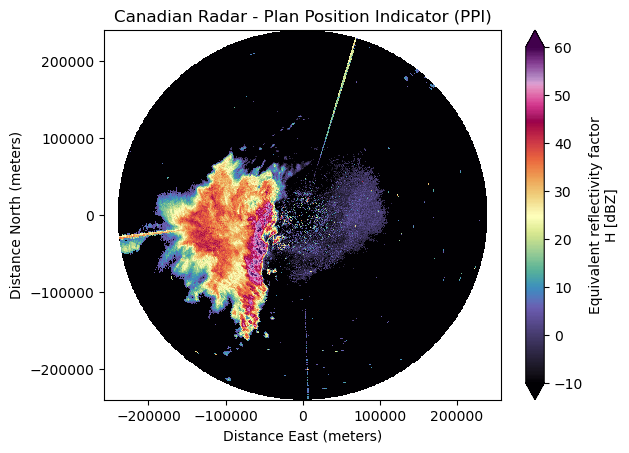

In [17]:
# Create a Plan Position Indicator (PPI) plot
ds_lowest.DBZH.plot(
    x="x", 
    y="y",
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
    # figsize=(10, 10)
)
plt.title('Canadian Radar - Plan Position Indicator (PPI)')
plt.xlabel('Distance East (meters)')
plt.ylabel('Distance North (meters)')
plt.axis('equal');  # Make the plot square for realistic geographic view

## Data slicing and analysis

One of the powerful features of `xarray` is the ability to easily slice and analyze data. Let's look at storm features within different distance ranges from the radar.

## Focus on storms within 100 km of the radar
ds_lowest.sel(range=slice(0, 100e3)).DBZH.plot(
    x="x", 
    y="y",
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
    figsize=(8, 8)
)
plt.title('Storm Features within 100 km')
plt.xlabel('Distance East (meters)')
plt.ylabel('Distance North (meters)')
plt.axis('equal')

Let's examine a specific sector of the storm by looking at data between 90 and 180 degrees azimuth

(np.float64(-99983.37010814976),
 np.float64(-2.713403168819184e-09),
 np.float64(-99983.43873370232),
 np.float64(-1.069306188039576e-08))

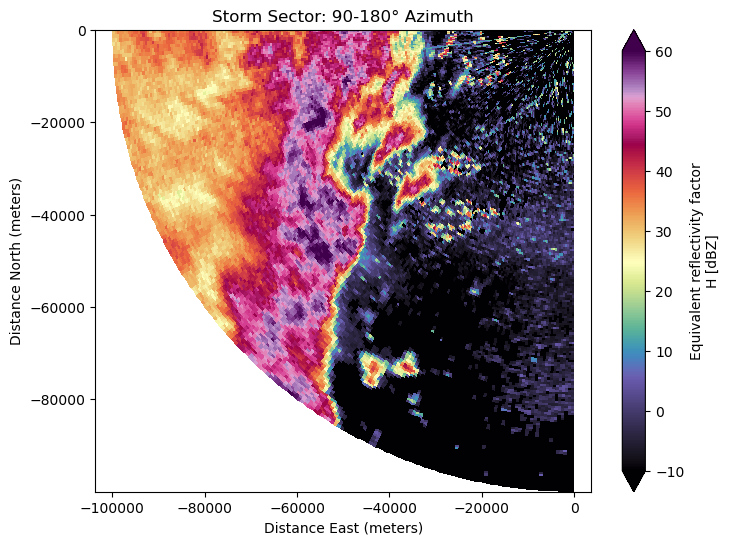

In [25]:
# Look at a specific sector of the storm (90-180 degrees azimuth, within 100 km)
sector_data = ds_lowest.sel(azimuth=slice(180, 270), range=slice(0, 100e3))
sector_data.DBZH.plot(
    x="x", 
    y="y",
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
    figsize=(8, 6)
)
plt.title('Storm Sector: 90-180° Azimuth')
plt.xlabel('Distance East (meters)')
plt.ylabel('Distance North (meters)')
plt.axis('equal')

We can also look at a "range-height" cross-section by selecting data along a specific azimuth angle

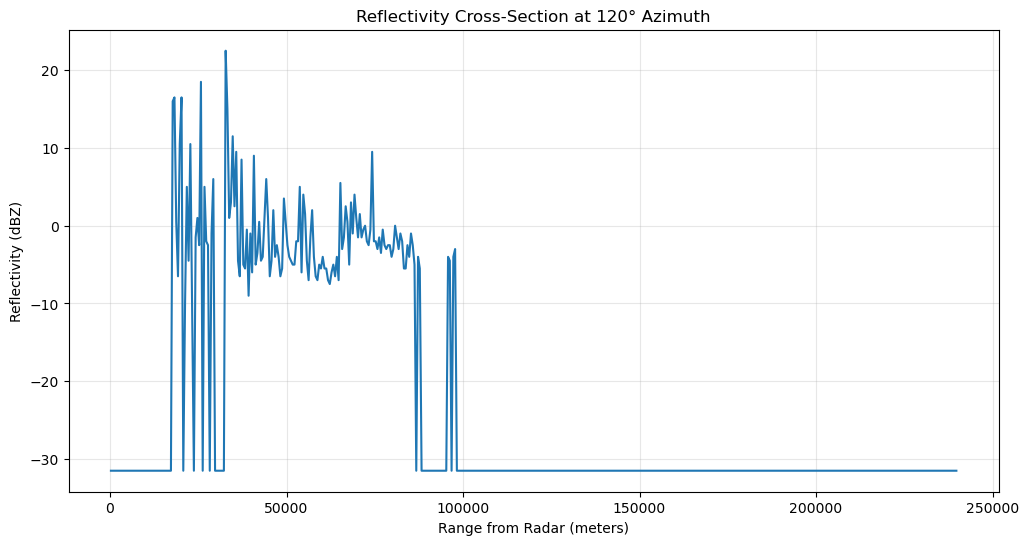

In [14]:
# Look at reflectivity along a specific direction (120 degrees azimuth)
cross_section = ds_lowest.sel(azimuth=120, method="nearest")
cross_section.DBZH.plot(figsize=(12, 6))
plt.title('Reflectivity Cross-Section at 120° Azimuth')
plt.xlabel('Range from Radar (meters)')
plt.ylabel('Reflectivity (dBZ)')
plt.grid(True, alpha=0.3)

## Xradar integration

### Py-Art

`Xradar` datatree objects can be ported to `Py-ART` radar objects using the pyart.xradar.Xradar method.

In [15]:
# Convert xradar DataTree to Py-ART radar object for advanced plotting
radar = pyart.xradar.Xradar(dt)

# Create a Py-ART radar map display
fig = plt.figure(figsize=[12, 10])
display = pyart.graph.RadarMapDisplay(radar)

# Plot the PPI with geographic context
display.plot_ppi_map('DBZH', sweep=0, 
                    vmin=-10, vmax=60, 
                    cmap='ChaseSpectral',
                    title='Canadian Radar - Ontario Derecho Event',
                    colorbar_label='Reflectivity (dBZ)')

# Add range rings for reference
display.plot_range_rings([50, 100, 150], lw=1, col='gray', ls='--')

AlignmentError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'azimuth' ('azimuth',) Error might be related to new default (`join='exact'`). Previously the default was `join='outer'`. The recommendation is to set 'join' explicitly for this case.

In [ ]:
del display

### Wradlib

`Wradlib` functionality can also be applied to `Xarray.Datatree` objects. For example, the [`wradlib.georef`](https://docs.wradlib.org/en/latest/georef.html) module can be used to enrich data by adding geographical coordinates.

In [18]:
# Apply wradlib georeferencing to add coordinate reference system information
for key in list(dt.children):
    if "sweep" in key:
        dt[key].ds = dt[key].ds.wrl.georef.georeference(
            crs=wrl.georef.get_default_projection()
        )

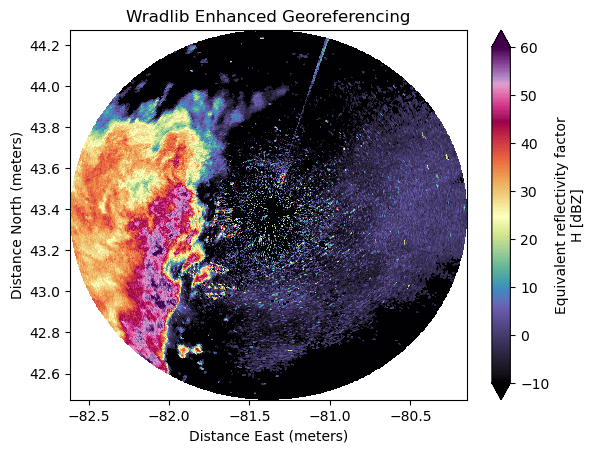

In [22]:
# Plot the wradlib-enhanced data
dt["sweep_16"].ds.DBZH.sel(range=slice(0, 100e3)).plot(
    x="x", 
    y="y",
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
)
plt.title('Wradlib Enhanced Georeferencing')
plt.xlabel('Distance East (meters)')
plt.ylabel('Distance North (meters)');

## Xradar exporters

Xradar supports exporting radar data to various formats for sharing and long-term storage. The supported export formats include:

- **CfRadial1 & CfRadial2**: Standard formats for radar data exchange
- **ODIM_H5**: European standard used by EUMETNET OPERA
- **Zarr**: Analysis-ready, cloud-optimized format that enhances data accessibility

Let's demonstrate exporting to Zarr format, which is excellent for cloud-based analysis and preserves the DataTree structure.

In [23]:
# Export the Canadian radar data to Zarr format
dt.to_zarr("canadian_radar.zarr", consolidated=True, mode="w")
print("✅ Data exported to Zarr format successfully!")

✅ Data exported to Zarr format successfully!


In [24]:
# Read the data back from Zarr to verify the export worked
dt_back = open_datatree("canadian_radar.zarr", engine="zarr", chunks={})
print("✅ Data successfully read back from Zarr format!")
print(f"Original sweeps: {len([k for k in dt.children if 'sweep' in k])}")
print(f"Restored sweeps: {len([k for k in dt_back.children if 'sweep' in k])}")

✅ Data successfully read back from Zarr format!
Original sweeps: 17
Restored sweeps: 17


In [ ]:
display(dt_back)

---

## Summary

`Xradar` is a powerful Python library for working with weather radar data that makes complex radar analysis accessible to students and researchers. Key learning points:

**📊 Data Access**: Xradar can read multiple radar formats (CfRadial, ODIM_H5, etc.) and organize data using xarray DataTree structures

**🗺️ Visualization**: Built-in georeferencing converts polar coordinates to geographic coordinates for intuitive storm visualization

**🔍 Analysis**: Xarray's slicing capabilities enable easy data exploration and cross-sectional analysis

**🔗 Integration**: Seamless connection with Py-ART and wradlib extends analysis capabilities

**☁️ Cloud-Ready**: Export to analysis-ready formats like Zarr for efficient cloud-based workflows

This Canadian Ontario Derecho case study demonstrates how xradar simplifies radar meteorology analysis for weather research and education.

## Resources and references
 - [Xradar](https://docs.openradarscience.org/projects/xradar/en/stable/index.html)
 - [Radar cookbook](https://github.com/ProjectPythia/radar-cookbook)
 - [Py-Art landing page](https://arm-doe.github.io/pyart/)
 - [Wradlib landing page](https://docs.wradlib.org/en/latest/index.html)
